In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
g = 9.81  # Gravitational acceleration [m/s^2]
hover_thrust = (5.3 * g) / 4  # Hover thrust = weight / # of rotors [N]
m = 5.3  # Mass of the quadcopter [kg]
k = 1.2  # Thrust coefficient (estimated)
kd = 0.05  # Drag coefficient (estimated)
L = 0.815 / 2  # Distance from center to rotor [m], assuming half of the wheelbase
b = 0.015  # Drag moment coefficient (estimated)
I = np.diag([0.1, 0.1, 0.2])  # Moment of inertia matrix [kg*m^2] (estimated)
dt = 0.005  # Time step (estimated)
start_time = 0
end_time = 180  # Total simulation time [s]
times = np.arange(start_time, end_time + dt, dt)

duration_hover = 120  # Time hovering [s] (2 min)
duration_circle = 60  # Time circling [s] (1 min)

def input_function(t):
    radius = 2.0  # Circle radius [m]
    speed_circle = 0.5  # Circle speed [m/s]

    inputs = np.array([hover_thrust, hover_thrust, hover_thrust, hover_thrust]) # Hover thrust accounting for each rotor

    # Hover 1m
    if t < duration_hover:
        return inputs # Equal thrusts in each rotor for vertical ascent and hover

    # Fly in a circle
    elif t < duration_hover + duration_circle:
        time_in_circle = t - duration_hover
        angle = (time_in_circle * speed_circle) / radius
        inputs[0] += 10 * np.sin(angle) # Sinusoidal variation creates circular flight path
        inputs[1] += 10 * np.cos(angle)
        inputs[2] -= 10 * np.sin(angle)
        inputs[3] -= 10 * np.cos(angle)
        return inputs

    # launch & vertical ascent, straight line & hover, yaw & hover, landing
    time_after_circle = t - (duration_hover + duration_circle)
    if time_after_circle < 5: # Launching and ascending vertically
        return np.array([hover_thrust + 50] * 4)
    elif time_after_circle < 10: # Moving in straight line
        inputs[0] += 20
        inputs[3] -= 20
        return inputs
    elif time_after_circle < 15: # Stop (hover)
        return inputs
    elif time_after_circle < 20: # Yaw 90 deg left
        return np.array([hover_thrust + 10, hover_thrust - 10, hover_thrust + 10, hover_thrust - 10])
    elif time_after_circle < 25: # Moving in straight line
        inputs[1] -= 20
        inputs[2] += 20
        return inputs
    elif time_after_circle < 30: # Stop (hover)
        return inputs
    else: # Landing
        landing_thrust = max(0, hover_thrust - 0.01 * 1000 * (time_after_circle - 30))
        return np.array([landing_thrust] * 4)

# Dynamics calculations
def thrust(inputs, k): # Calculate total thrust (z-direction)
    return np.array([0, 0, k * np.sum(inputs)])

def torques(inputs, L, b, k): # Calculate torques
    return np.array([
        L * k * (inputs[0] - inputs[2]), # Roll (x-direction)
        L * k * (inputs[1] - inputs[3]), # Pitch (y-direction)
        b * (inputs[0] - inputs[1] + inputs[2] - inputs[3]) # Yaw (z-axis)
    ])

def acceleration(inputs, angles, xdot, m, g, k, kd):
    gravity = np.array([0, 0, -g])
    R = rotation(angles) # Rotation matrix
    T = np.dot(R, thrust(inputs, k)) # Convert into inertial frame
    Fd = -kd * xdot
    return gravity + (1 / m) * T + Fd

def angular_acceleration(inputs, omega, I, L, b, k):
    tau = torques(inputs, L, b, k)
    return np.linalg.inv(I) @ (tau - np.cross(omega, np.dot(I, omega))) # Euler rotation

def thetadot2omega(thetadot, theta): # Convert angular velocity to body frame
    return thetadot

def omega2thetadot(omega, theta): # Convert angular velocity to inertial frame
    return omega

def rotation(angles): # Rotation matrix
    phi, theta, psi = angles
    R = np.array([
        [np.cos(psi) * np.cos(theta), np.cos(psi) * np.sin(theta) * np.sin(phi) - np.sin(psi) * np.cos(phi), 
         np.cos(psi) * np.sin(theta) * np.cos(phi) + np.sin(psi) * np.sin(phi)],
        [np.sin(psi) * np.cos(theta), np.sin(psi) * np.sin(theta) * np.sin(phi) + np.cos(psi) * np.cos(phi), 
         np.sin(psi) * np.sin(theta) * np.cos(phi) - np.cos(psi) * np.sin(phi)],
        [-np.sin(theta), np.cos(theta) * np.sin(phi), np.cos(theta) * np.cos(phi)]])
    return R

# Initial conditions
x = np.array([0.0, 0.0, 0.0])  # Position
xdot = np.zeros(3)  # Velocity
theta = np.zeros(3)  # Euler angles [phi/roll, theta/pitch, psi/yaw]
thetadot = np.zeros(3)  # Angular velocity [p, q, r]

positions = []
euler_angles = []

for t in times:
    i = input_function(t)

    omega = thetadot2omega(thetadot, theta) # Angular velocity

    a = acceleration(i, theta, xdot, m, g, k, kd)
    omegadot = angular_acceleration(i, omega, I, L, b, k)

    # Euler integration
    omega += dt * omegadot # Angular velocity
    thetadot = omega2thetadot(omega, theta) # Angular velocity in inertial frame
    theta += dt * thetadot # Euler angles
    xdot += dt * a # Velocity
    x += dt * xdot # Position
    
    positions.append(x.copy())
    euler_angles.append(theta.copy())

# Convert results to numpy arrays for easier handling later
positions = np.array(positions)
euler_angles = np.array(euler_angles)

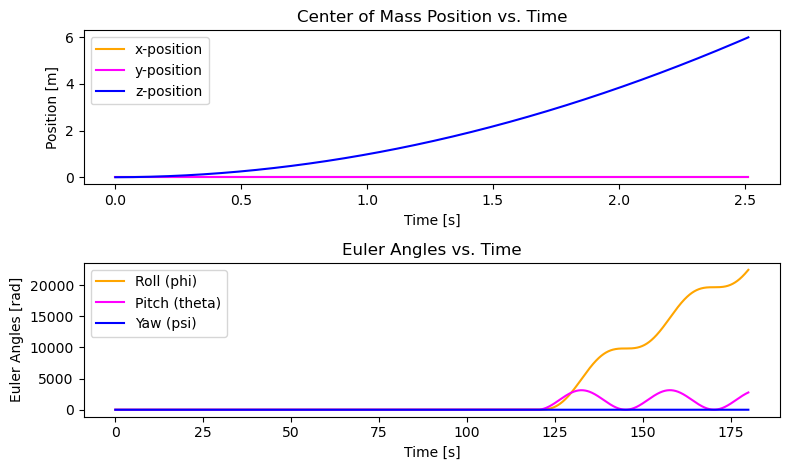

In [34]:
# Plot
plt.figure(figsize=(8, 4.8))
plt.subplot(2, 1, 1)

max_plot_distance = 6
indices = np.linalg.norm(positions, axis=1) <= max_plot_distance
plt.plot(times[indices], positions[indices, 0], label="x-position", color='orange')
plt.plot(times[indices], positions[indices, 1], label="y-position", color='magenta')
plt.plot(times[indices], positions[indices, 2], label="z-position", color='blue')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title('Center of Mass Position vs. Time')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(times[:len(euler_angles)], euler_angles[:, 0], label="Roll (phi)", color='orange')
plt.plot(times[:len(euler_angles)], euler_angles[:, 1], label="Pitch (theta)", color='magenta')
plt.plot(times[:len(euler_angles)], euler_angles[:, 2], label="Yaw (psi)", color='blue')
plt.xlabel('Time [s]')
plt.ylabel('Euler Angles [rad]')
plt.title('Euler Angles vs. Time')
plt.legend()

plt.tight_layout()
plt.show()